# Statistical methods

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sns.set_style(
    "whitegrid",  
    {  
        'legend.frameon': True,  
    }  
)
mpl.rc('figure', figsize=(14, 8))

## Means: the measures of centrality

Let $X_1,...,X_n$ denote our observations. The *arithmetic mean* is defined as
$$\mu=\frac{\sum_{i=1}^NX_i}{n}\,.$$

The *weighted mean* is defined as $$\sum_{i=1}^n w_i X_i$$, where $\sum w_i=1$.

The *median* is calculated by sorting a list `l`; suppose it has length $n$. Then the median is `l[(n+1)/2]` if $n$ is odd, or `avg(l[n/2],l[n/2+1])` if $n$ is even.

The *mode* is the most frequently occuring element, and can be calculated as follows.

In [2]:
x1 = [1, 2, 2, 3, 4, 5, 5, 7]
x2 = x1 + [100]

def mode(arr):
    counts={}
    for el in arr:
        if el in counts:
            counts[el]+=1
        else:
            counts[el]=1
    max_count=0
    modes=[]
    
    for (key, value) in counts.iteritems():
        if value > max_count:
            max_count= value
            modes=[key]
        elif value == max_count:
            modes.append(key)
            
    if max_count or len(arr):
        return modes
    else:
        return False

print "Modes of x1: ", mode(x1)

Modes of x1:  [2, 5]


Financial data is rarely discrete, so the mode may not be that useful. We can however bin them using `Numpy.histogram()`, and calculate the mode from there.

In [18]:
import requests

def get_stock_data(ticker, start_date, end_date, cols=None):
    url = 'https://www.quandl.com/api/v3/datasets/HKEX/' + ticker + '/data.json'
    params = {
        'start_date': start_date,
        'end_date': end_date,
        'api_key': 'CqRnybn2soNJPpEGZCy8',
        'column_index': cols,
    }
    cache_timeout = 1*60 # in seconds
    try:
        r = requests.get(url,params=params)
    except requests.exceptions.Timeout:
        return 0
    if r.headers['Content-Type'].startswith('text/html'):
        # 404 not found
        return 0
    else:
        return r.json()["dataset_data"]
    
stock = "00700"
start = "2017-01-01"
end = "2017-09-01"

res = get_stock_data(stock,start,end,cols=1)
prices = pd.Series([i[1] for i in res["data"]],index=pd.DatetimeIndex([i[0] for i in res["data"]]))[::-1]

returns = prices.pct_change()[1:]
hist,bins = np.histogram(returns, 20) # Break data up into 20 bins
print 'Mode of bins:', [(bins[i], bins[i+1]) for i, j in enumerate(hist) if j == max(hist)]

Mode of bins: [(-0.0029236422482373792, 0.0016829524981575028)]


The *geometric mean* is defined as
$$ G=(X_1...X_n)^{1/n} $$
for observations $X_i\geq0$. This can be calculated using `scipy.stats.gmean()`. For negative observations, we need to find a way of making the data positive. This is easy to do for asset returns, where we add `1` s.t. the percentage change becomes the ratio instead, and we get the *geometric mean return*
$$ R_G=\left((1+R_1)(1+R_2)...(1+R_T)\right)^{1/T} -1\,.$$

The geometric mean return is defined s.t. if the rate of return over the whole time period were constant and equal to $R_G$, the final price of the security would be equal to that of now, i.e. in the case of returns $R_1,...,R_T$.

In [20]:
import scipy.stats as stats

T = len(returns)
ratios = returns + np.ones(len(returns))
R_G = scipy.stats.gmean(ratios) - 1
print 'Geometric mean of returns:', R_G

init_price = prices[0]
final_price=prices[-1]
print 'Initial price:', init_price
print 'Final price:', final_price
print 'Final price as computed with R_G:', init_price*(1 + R_G)**T

Geometric mean of returns: 0.00332043650982
Initial price: 189.4
Final price: 326.2
Final price as computed with R_G: 326.2


Lastly, the *harmonic mean* is defined as
$$
H=\frac{n}{\sum_{i=1}^n\frac{1}{X_i}}\,.
$$
For non-negative numbers $X_i$, $\mu\geq G\geq H$, with equality holding if and only if $X_i$ are equal for all $i$.

## Variance: the measure of dispersion

One of the main ways risk is measured is in how spread out returns have been historically. If returns have been very tight around a central value, then we have less reason to worry. If returns have been all over the place, there is some risk involved. Data with low dispersion is heavily clustered around the mean, while high dispersion a indicates many very large and very small values.

Let's work with an array of random integers to represent our observations $X$.

In [22]:
# Generate 20 random integers < 100
X = np.random.randint(100, size=20)

# Sort them
X = np.sort(X)
print 'X: %s' %(X)

mu = np.mean(X)
print 'Mean of X:', mu

X: [ 1  6 14 23 26 28 29 45 47 52 56 57 59 73 74 81 86 90 95 98]
Mean of X: 52.0


The *range* of $X$ can be calculated using `Numpy.ptp()`, which gives the peak to peak difference.

In [23]:
print 'Range of X: %s' %(np.ptp(X))

Range of X: 97


The *mean absolute deviation (MAD)* is given by
$$
MAD=\frac{\sum_{i=1}^n|X_i-\mu|}{\mu}\,,
$$
for $n$ observations and its mean $\mu$. It is the average of the distances of observations from the arithmetic mean.

In [24]:
abs_dispersion = [np.abs(mu - x) for x in X]
MAD = np.sum(abs_dispersion)/len(abs_dispersion)
print 'Mean absolute deviation of X:', MAD

Mean absolute deviation of X: 24.9


The `variance` $\sigma^2$ is defined as
$$ \sigma^2=\frac{\sum_{i=1}^n(X_i-\mu)^2}{n}\,. $$
The `standard deviation` $\sigma$ is simply the square root of the variance. They can be calculated using `Numpy.var()` and `Numpy.std()`.

Chebyshev's inequality states that for a random variable $X$ with finite expected value $\mu$ and finite non-zero variance $\sigma^2$,
$$ \mathbb{P}(|X-\mu|>k\sigma)\leq\frac{1}{k^2}\,. $$
In other words, the probability of measuring a value $k$ standard deviations out of the mean is bounded above by $1/k^2$. Equivalently, at least $1−1/k^2$ of the pdf of $X$ have values that are within k standard deviations of the mean.

Note that this is a fairly loose bound as it applies to all distributions, provided their mean and variance is known.

In [25]:
k = 1.25
dist = k*np.std(X)
l = [x for x in X if abs(x - mu) <= dist]
print 'Observations within', k, 'stds of mean:', l
print 'Confirming that', float(len(l))/len(X), '>', 1 - 1/k**2

Observations within 1.25 stds of mean: [23, 26, 28, 29, 45, 47, 52, 56, 57, 59, 73, 74, 81, 86]
Confirming that 0.7 > 0.36


The variance and std do not distinguish between upward or downward deviations. It may thus often be useful to find the *semivariance*, given by
$$ \frac{\sum_{X_i<\mu}(X_i-\mu)^2}{n_<}\,, $$
where $n_<$ is the number of observations smaller than the mean. We also have the *semideviation*, which is the square root of the semivariance.

In [26]:
lows = [e for e in X if e <= mu]

semivar = np.sum( (lows - mu) ** 2 ) / len(lows)

print 'Semivariance of X:', semivar
print 'Semideviation of X:', np.sqrt(semivar)

Semivariance of X: 885.7
Semideviation of X: 29.7607123571


One can generalise the notion of semivariance to *target semivariance*, and analogously with semideviation, which simply replaces the mean by a parameter
$$ \frac{\sum_{X_i<B}(X_i-B)^2}{n_<B}\,.$$

## Linear regression

Linear regression is a technique that measures the relationship between two variables. If we have an independent variable $X$, and a dependent outcome variable $Y$, linear regression allows us to determine which linear model  $Y=\alpha+\beta X$  best explains the data. As an example, let's consider HSBC (00005) and Tencent (00700). We would like to know how HSBC varies as a function of how Tracker Fund varies, so we will take the daily returns of each and regress them against each other.

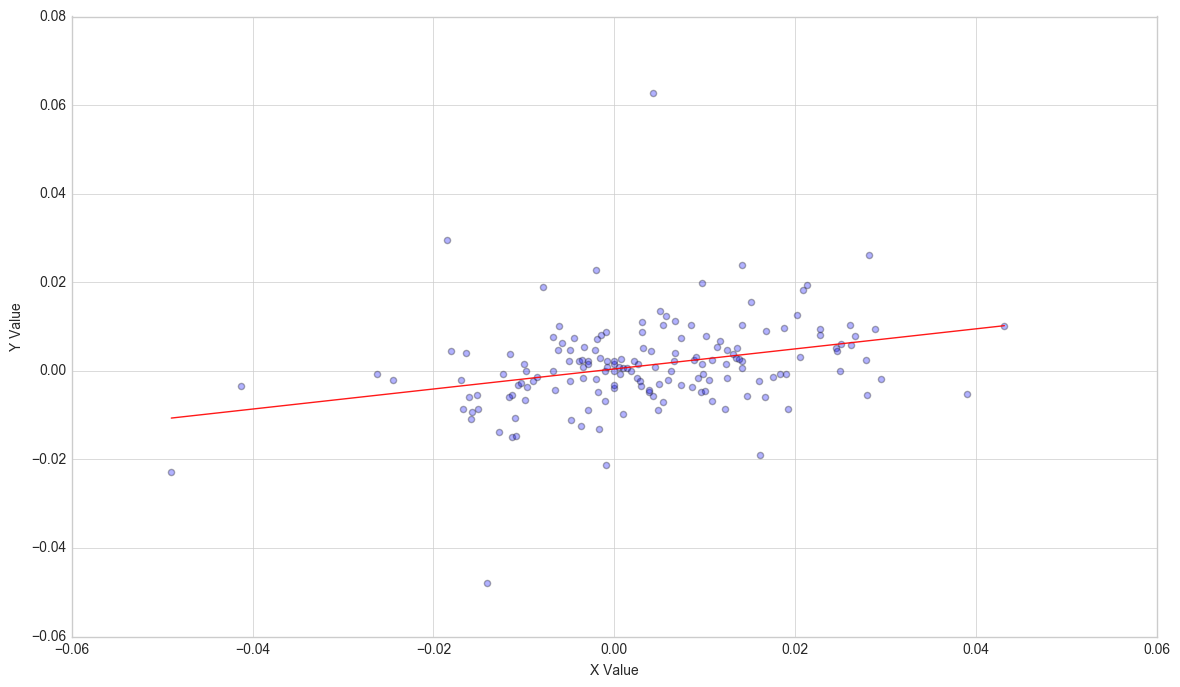

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     16.36
Date:                Tue, 12 Sep 2017   Prob (F-statistic):           8.10e-05
Time:                        01:55:19   Log-Likelihood:                 525.55
No. Observations:                 164   AIC:                            -1047.
Df Residuals:                     162   BIC:                            -1041.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.523      0.601      -0.001       0.002
x1             0.2264      0.056      4.044      0.000       0.116       0.337
==============================================================================
Omnibus:                       71.002   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              880.897
Skew:                           1.167   Prob(JB):                    5.20e-192
Kurtosis:                      14.112   Cond. No.                         72.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
from statsmodels import regression
import statsmodels.api as sm
import math

def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit() # OLS is ordinary least-squares
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    plt.show()
    return model.summary()

res = get_stock_data("00005",start,end,cols=1)
asset = pd.Series([i[1] for i in res["data"]],index=pd.DatetimeIndex([i[0] for i in res["data"]]))[::-1]
res = get_stock_data("00700",start,end,cols=1)
benchmark = pd.Series([i[1] for i in res["data"]],index=pd.DatetimeIndex([i[0] for i in res["data"]]))[::-1]

r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

linreg(r_b.values, r_a.values)

Each point on the above graph represents a day, with the x-coordinate being the return of Tracker Fund, and the y-coordinate being the return of HSBC. As we can see, the line of best fit tells us that for every 1% increased return we see from the Tracker Fund, we should see an extra 0.2264% from HSBC. This is expressed by the parameter $\beta$, which is 0.2264 as estimated. Of course, for decresed return we will also see about double the loss in HSBC, so we haven't gained anything, we are just more volatile.

Note that linear regression is different from correlation, but both are measures of covariance.
- Linear regression gives us a specific linear model, but is limited to cases of linear dependence.
- Correlation is general to linear and non-linear dependencies, but doesn't give us an actual model.
- Linear regression can give us relationship between Y and many independent variables by making X multidimensional.

Keep in mind also that the calculated parameters $\alpha$, $\beta$ are only estimates as well.

The regression model relies on several assumptions:
- That the independent variable is not random.
- That the variance of the error term is constant across observations. This is important for evaluating the goodness of the fit.
- That the errors are not autocorrelated. The Durbin-Watson statistic detects this: if it is close to 2, there is no autocorrelation.
- That the errors are normally distributed. If this does not hold, we cannot use some of the statistics, such as the F-test.

When making a prediction based on the model, it's useful to report not only a single value but a confidence interval. The linear regression reports 95% confidence intervals for the regression parameters, which we can visualise using the `seaborn` library.

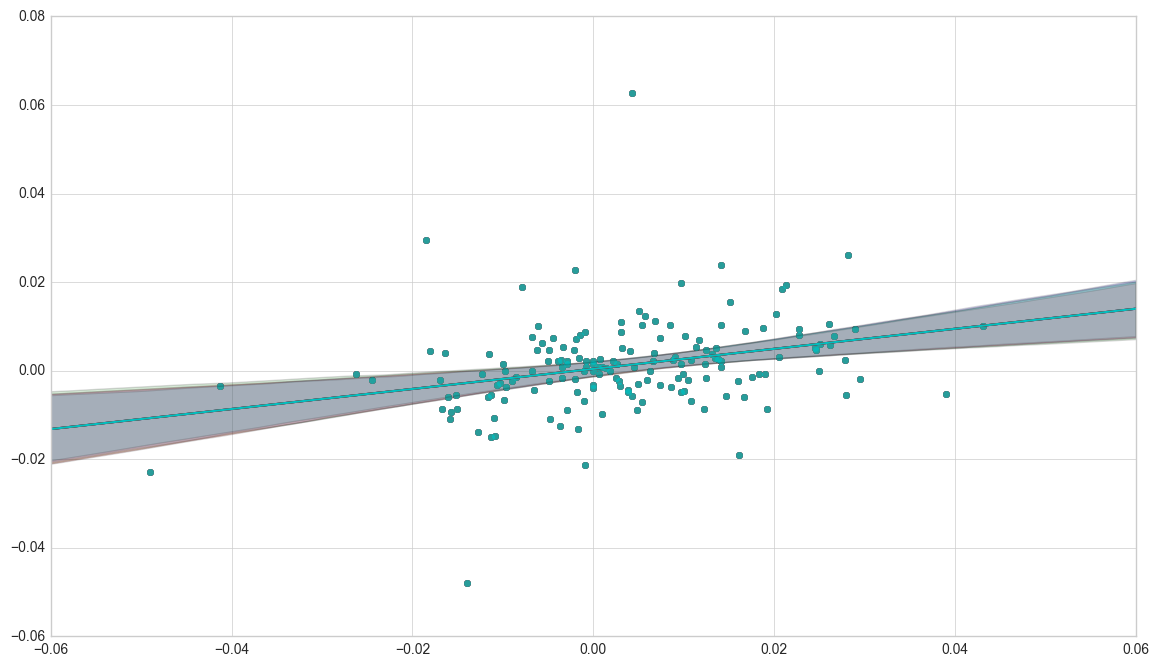

In [44]:
sns.regplot(r_b.values, r_a.values)
plt.show()

The mathematics behind this regression method is in optimising the placement of the line of best fit. The *ordinary least squares* (OLS) method does so by solving the following minimisation problem,
$$
\text{Find } \min_{a,b}Q(a,b)\text{ for }Q(a,b)=\sum_{i=1}^n\hat{\varepsilon}_i^2=\sum_{i=1}^n(Y_i-a-bX_i)^2\,.
$$
The resulting values of $\hat{\alpha}$ and $\hat{\beta}$ are in closed form,

$$
\begin{align}
\hat{\alpha}&=\bar{Y}-\hat{\beta}\bar{X}\,,\\
\hat{\beta}&=\frac{\sum_{i=1}^n(X_i-\bar{X})(Y_i-\bar{Y})}{\sum_{i=1}^n(X_i-\bar{X})^2}\\
&=\frac{\text{Cov}(X,Y)}{\text{Var}(X)}\,,
\end{align}
$$

where $\bar{X}$ and $\bar{Y}$ are the mean of samples $X$, $Y$ respectively, and $Cov$ denotes the sample covariance. Linear regression with OLS is called the *simple linear regression*.

## Multiple Linear Regression

We now generalise to $Y$ being a function of variables $X_1,...,X_k$. We want to express
$$
Y_i=\alpha+\beta_0X_{1_i}+...+\beta_k X_{k_i}+\varepsilon_i
$$
for observations $i=1,...,n$. To find the hyperplane of best fit using the OLS method, we now minimise $\sum_{i=1}^n\varepsilon_i^2$. Using a multivariate regression may be useful when two variables both correlated to another variable, such as Tencent and HSBC being correlated to the HSI. This method allows us to better gauge the significance between the two securities and the problem is known as confounding.

In [49]:
# Load pricing data for two arbitrarily-chosen assets and 2800
start = '2017-02-01'
end = '2017-09-01'

res = get_stock_data("00005",start,end,cols=1)
asset1 = pd.Series([i[1] for i in res["data"]],index=pd.DatetimeIndex([i[0] for i in res["data"]]))[::-1]
asset1.name="HSBC"
res = get_stock_data("00700",start,end,cols=1)
asset2 = pd.Series([i[1] for i in res["data"]],index=pd.DatetimeIndex([i[0] for i in res["data"]]))[::-1]
asset2.name="Tencent"
res = get_stock_data("02800",start,end,cols=1)
benchmark = pd.Series([i[1] for i in res["data"]],index=pd.DatetimeIndex([i[0] for i in res["data"]]))[::-1]
benchmark.name="HSI"

In [50]:
# First, run a linear regression on the two assets
slr = regression.linear_model.OLS(asset1, sm.add_constant(asset2)).fit()
print 'SLR beta of asset2:', slr.params[1]

# Run multiple linear regression using asset2 and 2800 as independent variables
mlr = regression.linear_model.OLS(asset1, sm.add_constant(np.column_stack((asset2, benchmark)))).fit()

prediction = mlr.params[0] + mlr.params[1]*asset2 + mlr.params[2]*benchmark
prediction.name = 'Prediction'

print 'MLR beta of asset2:', mlr.params[1], '\nMLR beta of HSI:', mlr.params[2]

SLR beta of asset2: 0.108837853008
MLR beta of asset2: -0.0646977146573 
MLR beta of HSI: 4.57839339202


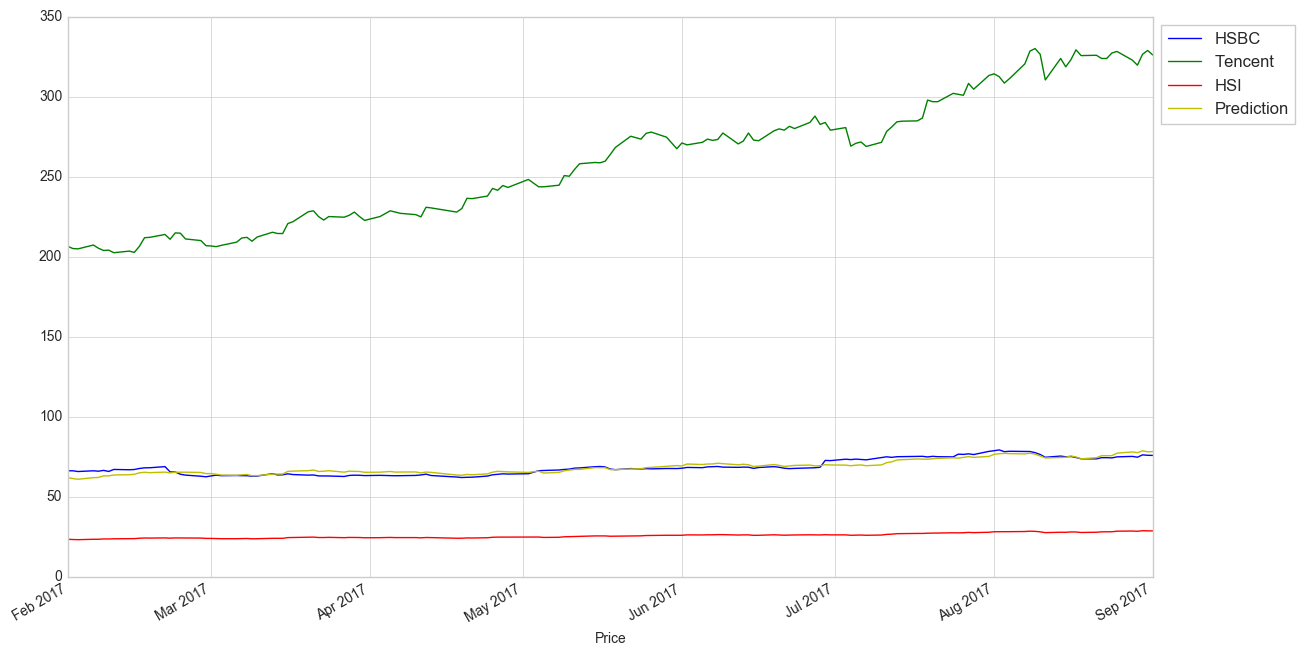

In [51]:
# Plot the three variables along with the prediction given by the MLR
asset1.plot()
asset2.plot()
benchmark.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()

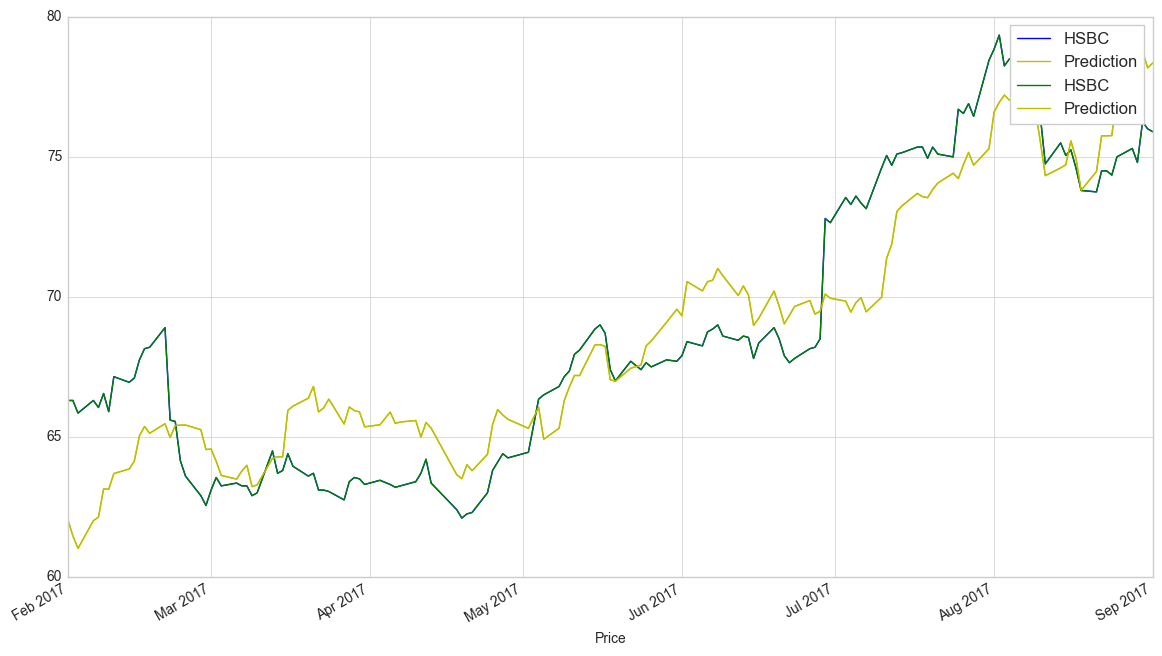

In [53]:
# Plot only the dependent variable and the prediction to get a closer look
asset1.plot()
prediction.plot(color='y')
plt.xlabel('Price')
plt.legend()
plt.show()

In [54]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   HSBC   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     339.5
Date:                Tue, 12 Sep 2017   Prob (F-statistic):           4.90e-55
Time:                        03:34:56   Log-Likelihood:                -315.18
No. Observations:                 146   AIC:                             636.4
Df Residuals:                     143   BIC:                             645.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.1679      9.312     -3.454      0.001     -50.575     -13.761
x1            -0.0647      0.022     -2.877      0.005      -0.109      -0.020
x2             4.5784      0.582      7.869      0.000       3.428       5.728
==============================================================================
Omnibus:                       16.367   Durbin-Watson:                   0.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.360
Skew:                           0.557   Prob(JB):                      0.00341
Kurtosis:                       2.210   Cond. No.                     1.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The model assumptions are the same as those from linear regression. Additionally, the independent variables have to be linearly independent, else the coefficients $\beta_i$ cannot be solved uniquely.

The summarised statistics above tell us things about the fit. For example, the $R^2$ value tells us the fraction of the total variation of $Y$ that is explained by the model. The adjusted $R^2$ is preferred however as it corrects for the small increases in $R^2$ that occur when we add more regression variables to the model, even if they are not significantly correlated with the dependent variable. It is defined as
$$
\text{Adj. }R^2=1-(1-R^2)\frac{n-1}{n-k-1}\,,
$$
where $n$ is the number of observations and $k$ is the number of independent variables in the model. 

## Linear correlation analysis

For two samples $X$, $Y$, the *correlation coefficient* is defined as
$$
r=\frac{\text{Cov}(X,Y)}{\text{Cov}(X,X)\text{Cov}(Y,Y)}=\frac{\text{Cov}(X,Y)}{\sigma(X)\sigma(Y)}
$$
where $\text{Cov}$ denotes the covariance and $\sigma$ is the standard deviation. Two sets of random data will have a correlation coefficient close to 0.

Correlation can be interpreted as a normalised covariance. It allows us to extract and compare information about $X$, $Y$ using their variance.